In [ ]:
import Config as C
import numpy as np
np.random.seed(C.SEED)
import random
random.seed(C.SEED)
from RewardFnSpace import *
import pickle
import more_itertools
from AcrobotUtils import *
from scipy.spatial.distance import pdist, squareform
import os
import os.path as osp
from A2C import *
from PlotUtils import *
from Eval import *
from rlpyt.samplers.serial.sampler import SerialSampler
from rlpyt.samplers.parallel.gpu.sampler import GpuSampler
from datetime import datetime
import joblib
from tqdm import tqdm
import torch
import gym
import time
from rlpyt.agents.pg.categorical import CategoricalPgAgent
from Network import *
from collections import namedtuple
from IPython.display import Video, display


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
d:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\IRL\RewardFnSpace.py:113: DeprecationWarning: invalid escape sequence '\s'
  """
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\rlpyt-0.1.2-py3.11.egg\rlpyt\utils\logging\tabulate.py:115: DeprecationWarning: invalid escape sequence '

In [2]:

def findSamplesInTrajs (stateSamples, trajs) : 
    """ 
    For each state sample, find all indices (i, j) such that
    the jth state in ith trajectory is approximately the state
    sample
    """
    nSamples = stateSamples.shape[0]
    stateOccurenceIndices = [[] for _ in range(nSamples)]
    allStates = [np.stack([s for s, _, _ in t]) for t in trajs]
    for i, traj in enumerate(trajs) : 
        trajLen = len(traj)
        D = squareform(pdist(np.concatenate((stateSamples, allStates[i]), axis=0)))
        D = D[:nSamples, nSamples:]
        indices = np.where(D < C.STATE_SIMILARITY_THRESH)
        for j, k  in zip(*indices) : 
            stateOccurenceIndices[j].append((i, k))
    return stateOccurenceIndices


In [3]:
def generateStateSamples (trajs, nSamples) : 
    """ get the distribution of start states """
    allStates = [[s for s, _, _ in t] for t in trajs[:10]]
    allStates = list(more_itertools.flatten(allStates))
    states = random.sample(allStates, k=nSamples)
    states = np.array(states)
    return states

In [4]:
def estimateValueFromTrajs (stateIndices, trajs, rewardFn) :
    """ 
    Estimate the value for each state from expert 
    trajectories.
    """
    def computeReturnOnTraj (traj) : 
        R = [rewardFn(s) for s, _, _ in traj]
        return computeReturns(R, C.DISCOUNT)[0]
    values = []
    for i, indices in enumerate(stateIndices) : 
        truncatedTrajs = [trajs[i][j:] for i, j in indices] 
        vhat = np.mean([computeReturnOnTraj(t) for t in truncatedTrajs])
        values.append(vhat)
    return values

In [5]:
def estimateValueFromAgent (stateSamples, agent, rewardFn) : 
    """
    Use the learnt value function network through
    A2C to estimate value for states.
    """
    def estimateForState (s) : 
        cpus = list(range(C.N_PARALLEL))
        affinity = dict(cuda_idx=C.CUDA_IDX, workers_cpus=cpus)
        agent_ = CategoricalPgAgent(
            AcrobotNet, 
            initial_model_state_dict=agent.state_dict())
        sampler = SerialSampler(
            EnvCls=rlpyt_make,
            env_kwargs=dict(
                id=C.ENV, 
                reward=rewardFn, 
                internalStateFn=C.INTERNAL_STATE_FN, 
                s0=s),
            batch_T=C.HORIZON,
            batch_B=C.BATCH_B,
            max_decorrelation_steps=0,
        )
        sampler.initialize(
            agent=agent_,
            affinity=affinity,
            seed=C.SEED
        )
        _, traj_info = sampler.obtain_samples(0)
        returns = [t['DiscountedReturn'] for t in traj_info]
        return np.mean(returns)
    estimates = list(map(estimateForState, stateSamples))
    return estimates


In [6]:
def save_agent_and_reward_fn(agent, reward_fn, directory='results'):
    """
    Lưu agent và reward function bằng joblib
    
    Args:
        agent: Agent được đào tạo
        reward_fn: Hàm reward đã được tìm ra
        directory: Thư mục để lưu file (mặc định là 'results')
    """
    # Tạo thư mục nếu chưa tồn tại
    os.makedirs(directory, exist_ok=True)
    
    # Tạo timestamp để đặt tên file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Lưu agent
    agent_path = osp.join(directory, f'agent_{timestamp}.joblib')
    joblib.dump(agent.state_dict(), agent_path)
    print(f"Agent saved to {agent_path}")
    
    # Lưu reward function
    reward_fn_path = osp.join(directory, f'reward_fn_{timestamp}.joblib')
    joblib.dump(reward_fn, reward_fn_path)
    print(f"Reward function saved to {reward_fn_path}")
    
    return agent_path, reward_fn_path

def load_agent_and_reward_fn(agent_path, reward_fn_path):
    """
    Tải lại agent và reward function đã lưu
    
    Args:
        agent_path: Đường dẫn file agent đã lưu
        reward_fn_path: Đường dẫn file reward function đã lưu
    
    Returns:
        tuple: (agent, reward_fn)
    """
    # Tải lại reward function
    reward_fn = joblib.load(reward_fn_path)
    
    # Tải lại state dict của agent
    agent_state_dict = joblib.load(agent_path)
    
    # Khởi tạo lại agent với state dict đã lưu
    agent = CategoricalPgAgent(AcrobotNet)
    agent.load_state_dict(agent_state_dict)
    
    return agent, reward_fn

In [7]:
def getAllTraj () : 
    """ get all trajectories from C.TRAJ_DIR """
    def loadPickle (f) : 
        with open(osp.join(C.TRAJ_DIR, f), 'rb') as fd : 
            return pickle.load(fd)
    return list(map(loadPickle, os.listdir(C.TRAJ_DIR)))

In [8]:
def irl (rewardFnSpace) :
    """
    Find the explanatory reward function for expert's 
    policy in the space of reward functions.
    """
    trajs = getAllTraj()
    stateSamples = generateStateSamples(trajs, C.IRL_STATE_SAMPLES)
    indices = findSamplesInTrajs(stateSamples, trajs) 
    for i in range(C.IRL_ITR) : 
        rewardFn = rewardFnSpace.current()
        agent = findOptimalAgent(rewardFn)
        env = rlpyt_make('Acrobot-v1', internalStateFn=C.INTERNAL_STATE_FN)
        expertValues = [estimateValueFromTrajs(indices, trajs, _) 
                        for _ in rewardFnSpace.rewardBases]
        inferiorValues = [estimateValueFromAgent(stateSamples, agent, _)
                          for _ in rewardFnSpace.rewardBases]
        rewardFnSpace.refine(expertValues, inferiorValues)
    return agent, rewardFn

In [ ]:

def simulateAgentFile(agentFile, render=False):
    """ Load rlpyt agent from file and simulate  """
    state_dict = torch.load(agentFile, map_location=torch.device('cpu'))
    agent = CategoricalPgAgent(AcrobotNet)
    env = gym.make('Acrobot-v1')
    EnvSpace = namedtuple('EnvSpace', ['action', 'observation'])
    agent.initialize(EnvSpace(env.action_space, env.observation_space))
    agent.load_state_dict(state_dict)
    return simulateAgent(agent, render)

def simulateAgent(agent, render=False):
    """ Simulate agent on environment and save video """
    env = gym.make('Acrobot-v1', render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, "video/", episode_trigger=lambda x: True)
    
    done = False
    s = torch.tensor(env.reset()).float()
    a = torch.tensor(0)
    r = torch.tensor(0).float()
    steps = 0
    
    while not done:
        steps += 1
        if render:
            env.render()
            time.sleep(0.05)
        
        a = agent.step(s, a, r).action
        s_, r, done, _ = env.step(a.item())
        s_ = torch.tensor(s_).float()
        r = torch.tensor(r).float()
        s = s_
    
    env.close()
    return steps


In [ ]:
# Chạy thuật toán IRL
rewardFnSpace = RewardFnSpace(acrobotRewardBases(np.pi / 2, np.pi / 2))
agent, rewardFn = irl(rewardFnSpace)

d:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\IRL\a2c_acrobot-v1\run_0
D:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\Inverse-Reinforcement-Learning\rlpyt\data
2024-11-21 19:22:07.762595  | a2c_acrobot-v1_0 Runner  master CPU affinity: [0, 1, 2, 3, 4, 5, 6, 7].
2024-11-21 19:22:07.762595  | a2c_acrobot-v1_0 Runner  master Torch threads: 4.
using seed 3674
2024-11-21 19:22:07.857254  | a2c_acrobot-v1_0 Sampler decorrelating envs, max steps: 400


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym

2024-11-21 19:22:10.647896  | a2c_acrobot-v1_0 Serial Sampler initialized.
2024-11-21 19:22:10.647896  | a2c_acrobot-v1_0 Running 1872 iterations of minibatch RL.
2024-11-21 19:22:14.760579  | a2c_acrobot-v1_0 Optimizing over 312 iterations.


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\rlpyt-0.1.2-py3.11.egg\rlpyt\algos\pg\a2c.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:24:17.827468  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-21 19:24:17.837281  | a2c_acrobot-v1_0 itr #311 saved
2024-11-21 19:24:17.840730  | -----------------------------  -------------
2024-11-21 19:24:17.840730  | Diagnostics/NewCompletedTrajs    429
2024-11-21 19:24:17.840730  | Diagnostics/StepsInTrajWindow  14129
2024-11-21 19:24:17.840730  | Diagnostics/Iteration            311
2024-11-21 19:24:17.840730  | Diagnostics/CumTime (s)          123.079
2024-11-21 19:24:17.840730  | Diagnostics/CumSteps           99840
2024-11-21 19:24:17.852167  | Diagnostics/CumCompletedTrajs    429
2024-11-21 19:24:17.853164  | Diagnostics/CumUpdates           312
2024-11-21 19:24:17.855157  | Diagnostics/StepsPerSecond       811.188
2024-11-21 19:24:17.855629  | Diagnostics/UpdatesPerSecond       2.53496
2024-11-21 19:24:17.855629  | Diagnostics/ReplayRatio            1
2024-11-21 19:24:17.855629  | Diagnostics/CumReplayRatio         1
2024-11-21 19:24:17.855629  | LengthA


Total time elapsed: 00:02:03
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:26:24.967884  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-21 19:26:24.973874  | a2c_acrobot-v1_0 itr #623 saved
2024-11-21 19:26:24.979088  | -----------------------------  --------------
2024-11-21 19:26:24.979088  | Diagnostics/NewCompletedTrajs    1075
2024-11-21 19:26:24.985596  | Diagnostics/StepsInTrajWindow    9096
2024-11-21 19:26:24.985596  | Diagnostics/Iteration             623
2024-11-21 19:26:24.985596  | Diagnostics/CumTime (s)           250.214
2024-11-21 19:26:24.985596  | Diagnostics/CumSteps           199680
2024-11-21 19:26:24.989159  | Diagnostics/CumCompletedTrajs    1504
2024-11-21 19:26:24.991230  | Diagnostics/CumUpdates            624
2024-11-21 19:26:24.992147  | Diagnostics/StepsPerSecond        785.303
2024-11-21 19:26:24.992764  | Diagnostics/UpdatesPerSecond        2.45407
2024-11-21 19:26:24.992764  | Diagnostics/ReplayRatio             1
2024-11-21 19:26:24.997315  | Diagnostics/CumReplayRatio          1
2024-11-21 19:26:24.99831


Total time elapsed: 00:02:07
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:28:28.090052  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-21 19:28:28.107073  | a2c_acrobot-v1_0 itr #935 saved
2024-11-21 19:28:28.114599  | -----------------------------  --------------
2024-11-21 19:28:28.114599  | Diagnostics/NewCompletedTrajs    1146
2024-11-21 19:28:28.114599  | Diagnostics/StepsInTrajWindow    8469
2024-11-21 19:28:28.114599  | Diagnostics/Iteration             935
2024-11-21 19:28:28.114599  | Diagnostics/CumTime (s)           373.346
2024-11-21 19:28:28.114599  | Diagnostics/CumSteps           299520
2024-11-21 19:28:28.123680  | Diagnostics/CumCompletedTrajs    2650
2024-11-21 19:28:28.123680  | Diagnostics/CumUpdates            936
2024-11-21 19:28:28.123680  | Diagnostics/StepsPerSecond        810.836
2024-11-21 19:28:28.123680  | Diagnostics/UpdatesPerSecond        2.53386
2024-11-21 19:28:28.123680  | Diagnostics/ReplayRatio             1
2024-11-21 19:28:28.123680  | Diagnostics/CumReplayRatio          1
2024-11-21 19:28:28.12368


Total time elapsed: 00:02:03
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:30:30.505001  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-21 19:30:30.524832  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-21 19:30:30.531815  | -----------------------------  --------------
2024-11-21 19:30:30.532812  | Diagnostics/NewCompletedTrajs    1146
2024-11-21 19:30:30.533810  | Diagnostics/StepsInTrajWindow    8733
2024-11-21 19:30:30.535391  | Diagnostics/Iteration            1247
2024-11-21 19:30:30.535391  | Diagnostics/CumTime (s)           495.766
2024-11-21 19:30:30.535391  | Diagnostics/CumSteps           399360
2024-11-21 19:30:30.535391  | Diagnostics/CumCompletedTrajs    3796
2024-11-21 19:30:30.535391  | Diagnostics/CumUpdates           1248
2024-11-21 19:30:30.535391  | Diagnostics/StepsPerSecond        815.555
2024-11-21 19:30:30.535391  | Diagnostics/UpdatesPerSecond        2.54861
2024-11-21 19:30:30.535391  | Diagnostics/ReplayRatio             1
2024-11-21 19:30:30.535391  | Diagnostics/CumReplayRatio          1
2024-11-21 19:30:30.535


Total time elapsed: 00:02:02
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:32:33.495457  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-21 19:32:33.495457  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-21 19:32:33.495457  | -----------------------------  --------------
2024-11-21 19:32:33.495457  | Diagnostics/NewCompletedTrajs    1135
2024-11-21 19:32:33.495457  | Diagnostics/StepsInTrajWindow    9042
2024-11-21 19:32:33.512249  | Diagnostics/Iteration            1559
2024-11-21 19:32:33.512249  | Diagnostics/CumTime (s)           618.735
2024-11-21 19:32:33.512249  | Diagnostics/CumSteps           499200
2024-11-21 19:32:33.512249  | Diagnostics/CumCompletedTrajs    4931
2024-11-21 19:32:33.519594  | Diagnostics/CumUpdates           1560
2024-11-21 19:32:33.520597  | Diagnostics/StepsPerSecond        811.914
2024-11-21 19:32:33.521625  | Diagnostics/UpdatesPerSecond        2.53723
2024-11-21 19:32:33.521806  | Diagnostics/ReplayRatio             1
2024-11-21 19:32:33.521806  | Diagnostics/CumReplayRatio          1
2024-11-21 19:32:33.521


Total time elapsed: 00:02:02
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:34:24.327251  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-21 19:34:24.327251  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-21 19:34:24.340140  | -----------------------------  --------------
2024-11-21 19:34:24.340140  | Diagnostics/NewCompletedTrajs    1109
2024-11-21 19:34:24.340140  | Diagnostics/StepsInTrajWindow    9006
2024-11-21 19:34:24.340140  | Diagnostics/Iteration            1871
2024-11-21 19:34:24.340140  | Diagnostics/CumTime (s)           729.58
2024-11-21 19:34:24.340140  | Diagnostics/CumSteps           599040
2024-11-21 19:34:24.340140  | Diagnostics/CumCompletedTrajs    6040
2024-11-21 19:34:24.340140  | Diagnostics/CumUpdates           1872
2024-11-21 19:34:24.356998  | Diagnostics/StepsPerSecond        900.72
2024-11-21 19:34:24.357994  | Diagnostics/UpdatesPerSecond        2.81475
2024-11-21 19:34:24.358674  | Diagnostics/ReplayRatio             1
2024-11-21 19:34:24.360673  | Diagnostics/CumReplayRatio          1
2024-11-21 19:34:24.36167


Total time elapsed: 00:01:50
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2024-11-21 19:34:25.110186  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:25.110186  | Serial Sampler initialized.


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


2024-11-21 19:34:28.244145  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:28.256301  | Serial Sampler initialized.
2024-11-21 19:34:31.689705  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:31.689705  | Serial Sampler initialized.
2024-11-21 19:34:35.123010  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:35.123010  | Serial Sampler initialized.
2024-11-21 19:34:38.506199  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:38.506199  | Serial Sampler initialized.
2024-11-21 19:34:41.976971  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:41.976971  | Serial Sampler initialized.
2024-11-21 19:34:45.167095  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:45.168093  | Serial Sampler initialized.
2024-11-21 19:34:48.463720  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:48.463720  | Serial Sampler initialized.
2024-11-21 19:34:51.738752  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:34:51.738752

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\pulp\pulp.py:1650: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


2024-11-21 19:42:32.705328  | a2c_acrobot-v1_0 Serial Sampler initialized.
2024-11-21 19:42:32.706333  | a2c_acrobot-v1_0 Running 1872 iterations of minibatch RL.
2024-11-21 19:42:32.706619  | a2c_acrobot-v1_0 Optimizing over 312 iterations.


0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:44:03.588694  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-21 19:44:03.596943  | a2c_acrobot-v1_0 itr #311 saved
2024-11-21 19:44:03.607842  | -----------------------------  ------------
2024-11-21 19:44:03.609700  | Diagnostics/NewCompletedTrajs    902
2024-11-21 19:44:03.611693  | Diagnostics/StepsInTrajWindow   8576
2024-11-21 19:44:03.612692  | Diagnostics/Iteration            311
2024-11-21 19:44:03.613463  | Diagnostics/CumTime (s)           90.8904
2024-11-21 19:44:03.615581  | Diagnostics/CumSteps           99840
2024-11-21 19:44:03.616455  | Diagnostics/CumCompletedTrajs    902
2024-11-21 19:44:03.617453  | Diagnostics/CumUpdates           312
2024-11-21 19:44:03.618450  | Diagnostics/StepsPerSecond      1098.47
2024-11-21 19:44:03.621038  | Diagnostics/UpdatesPerSecond       3.4327
2024-11-21 19:44:03.621038  | Diagnostics/ReplayRatio            1
2024-11-21 19:44:03.621038  | Diagnostics/CumReplayRatio         1
2024-11-21 19:44:03.621038  | LengthAve


Total time elapsed: 00:01:30
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:45:36.458798  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-21 19:45:36.479651  | a2c_acrobot-v1_0 itr #623 saved
2024-11-21 19:45:36.484638  | -----------------------------  --------------
2024-11-21 19:45:36.485634  | Diagnostics/NewCompletedTrajs    1142
2024-11-21 19:45:36.485634  | Diagnostics/StepsInTrajWindow    8925
2024-11-21 19:45:36.487633  | Diagnostics/Iteration             623
2024-11-21 19:45:36.488630  | Diagnostics/CumTime (s)           183.773
2024-11-21 19:45:36.489626  | Diagnostics/CumSteps           199680
2024-11-21 19:45:36.490622  | Diagnostics/CumCompletedTrajs    2044
2024-11-21 19:45:36.492614  | Diagnostics/CumUpdates            624
2024-11-21 19:45:36.493614  | Diagnostics/StepsPerSecond       1074.9
2024-11-21 19:45:36.494609  | Diagnostics/UpdatesPerSecond        3.35908
2024-11-21 19:45:36.495607  | Diagnostics/ReplayRatio             1
2024-11-21 19:45:36.496603  | Diagnostics/CumReplayRatio          1
2024-11-21 19:45:36.498598 


Total time elapsed: 00:01:32
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:47:08.088425  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-21 19:47:08.094986  | a2c_acrobot-v1_0 itr #935 saved
2024-11-21 19:47:08.098974  | -----------------------------  --------------
2024-11-21 19:47:08.099972  | Diagnostics/NewCompletedTrajs    1144
2024-11-21 19:47:08.100969  | Diagnostics/StepsInTrajWindow    8787
2024-11-21 19:47:08.102965  | Diagnostics/Iteration             935
2024-11-21 19:47:08.104016  | Diagnostics/CumTime (s)           275.387
2024-11-21 19:47:08.105020  | Diagnostics/CumSteps           299520
2024-11-21 19:47:08.107012  | Diagnostics/CumCompletedTrajs    3188
2024-11-21 19:47:08.108010  | Diagnostics/CumUpdates            936
2024-11-21 19:47:08.110005  | Diagnostics/StepsPerSecond       1089.79
2024-11-21 19:47:08.111004  | Diagnostics/UpdatesPerSecond        3.40558
2024-11-21 19:47:08.112003  | Diagnostics/ReplayRatio             1
2024-11-21 19:47:08.112997  | Diagnostics/CumReplayRatio          1
2024-11-21 19:47:08.113994


Total time elapsed: 00:01:31
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:48:39.453297  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-21 19:48:39.468736  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-21 19:48:39.475717  | -----------------------------  --------------
2024-11-21 19:48:39.476716  | Diagnostics/NewCompletedTrajs    1108
2024-11-21 19:48:39.476716  | Diagnostics/StepsInTrajWindow    9293
2024-11-21 19:48:39.478710  | Diagnostics/Iteration            1247
2024-11-21 19:48:39.479706  | Diagnostics/CumTime (s)           366.761
2024-11-21 19:48:39.480704  | Diagnostics/CumSteps           399360
2024-11-21 19:48:39.482928  | Diagnostics/CumCompletedTrajs    4296
2024-11-21 19:48:39.484069  | Diagnostics/CumUpdates           1248
2024-11-21 19:48:39.486063  | Diagnostics/StepsPerSecond       1092.66
2024-11-21 19:48:39.487063  | Diagnostics/UpdatesPerSecond        3.41455
2024-11-21 19:48:39.488057  | Diagnostics/ReplayRatio             1
2024-11-21 19:48:39.490052  | Diagnostics/CumReplayRatio          1
2024-11-21 19:48:39.4912


Total time elapsed: 00:01:31
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:50:10.082786  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-21 19:50:10.088769  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-21 19:50:10.093277  | -----------------------------  --------------
2024-11-21 19:50:10.094274  | Diagnostics/NewCompletedTrajs    1082
2024-11-21 19:50:10.095274  | Diagnostics/StepsInTrajWindow    9645
2024-11-21 19:50:10.096987  | Diagnostics/Iteration            1559
2024-11-21 19:50:10.098429  | Diagnostics/CumTime (s)           457.381
2024-11-21 19:50:10.099434  | Diagnostics/CumSteps           499200
2024-11-21 19:50:10.100431  | Diagnostics/CumCompletedTrajs    5378
2024-11-21 19:50:10.101426  | Diagnostics/CumUpdates           1560
2024-11-21 19:50:10.102570  | Diagnostics/StepsPerSecond       1101.74
2024-11-21 19:50:10.103567  | Diagnostics/UpdatesPerSecond        3.44295
2024-11-21 19:50:10.104568  | Diagnostics/ReplayRatio             1
2024-11-21 19:50:10.106543  | Diagnostics/CumReplayRatio          1
2024-11-21 19:50:10.1065


Total time elapsed: 00:01:30
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 19:51:53.646596  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-21 19:51:53.655096  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-21 19:51:53.662834  | -----------------------------  ---------------
2024-11-21 19:51:53.662834  | Diagnostics/NewCompletedTrajs    1071
2024-11-21 19:51:53.662834  | Diagnostics/StepsInTrajWindow    8819
2024-11-21 19:51:53.662834  | Diagnostics/Iteration            1871
2024-11-21 19:51:53.667265  | Diagnostics/CumTime (s)           560.948
2024-11-21 19:51:53.668269  | Diagnostics/CumSteps           599040
2024-11-21 19:51:53.669265  | Diagnostics/CumCompletedTrajs    6449
2024-11-21 19:51:53.670262  | Diagnostics/CumUpdates           1872
2024-11-21 19:51:53.671771  | Diagnostics/StepsPerSecond        964.02
2024-11-21 19:51:53.672276  | Diagnostics/UpdatesPerSecond        3.01256
2024-11-21 19:51:53.673172  | Diagnostics/ReplayRatio             1
2024-11-21 19:51:53.674970  | Diagnostics/CumReplayRatio          1
2024-11-21 19:51:53.675


Total time elapsed: 00:01:43


2024-11-21 19:51:54.632940  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:51:54.635032  | Serial Sampler initialized.
2024-11-21 19:51:58.155244  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:51:58.156241  | Serial Sampler initialized.
2024-11-21 19:52:01.768564  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:52:01.769561  | Serial Sampler initialized.
2024-11-21 19:52:05.836557  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:52:05.837557  | Serial Sampler initialized.
2024-11-21 19:52:09.342482  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:52:09.344338  | Serial Sampler initialized.
2024-11-21 19:52:12.742579  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:52:12.758204  | Serial Sampler initialized.
2024-11-21 19:52:15.985347  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:52:15.985347  | Serial Sampler initialized.
2024-11-21 19:52:18.676676  | Sampler decorrelating envs, max steps: 0
2024-11-21 19:52:18.676676

0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:05:07.175897  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-21 20:05:07.191382  | a2c_acrobot-v1_0 itr #311 saved
2024-11-21 20:05:07.200906  | -----------------------------  ------------
2024-11-21 20:05:07.202900  | Diagnostics/NewCompletedTrajs    200
2024-11-21 20:05:07.205406  | Diagnostics/StepsInTrajWindow  50000
2024-11-21 20:05:07.207411  | Diagnostics/Iteration            311
2024-11-21 20:05:07.208403  | Diagnostics/CumTime (s)          172.849
2024-11-21 20:05:07.209401  | Diagnostics/CumSteps           99840
2024-11-21 20:05:07.211401  | Diagnostics/CumCompletedTrajs    200
2024-11-21 20:05:07.211401  | Diagnostics/CumUpdates           312
2024-11-21 20:05:07.213936  | Diagnostics/StepsPerSecond       577.615
2024-11-21 20:05:07.214933  | Diagnostics/UpdatesPerSecond       1.80505
2024-11-21 20:05:07.216935  | Diagnostics/ReplayRatio            1
2024-11-21 20:05:07.217931  | Diagnostics/CumReplayRatio         1
2024-11-21 20:05:07.218928  | LengthAv


Total time elapsed: 00:02:52
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:08:09.579462  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-21 20:08:09.594080  | a2c_acrobot-v1_0 itr #623 saved
2024-11-21 20:08:09.605118  | -----------------------------  --------------
2024-11-21 20:08:09.607119  | Diagnostics/NewCompletedTrajs     200
2024-11-21 20:08:09.609112  | Diagnostics/StepsInTrajWindow   50000
2024-11-21 20:08:09.611106  | Diagnostics/Iteration             623
2024-11-21 20:08:09.613677  | Diagnostics/CumTime (s)           355.252
2024-11-21 20:08:09.615685  | Diagnostics/CumSteps           199680
2024-11-21 20:08:09.617675  | Diagnostics/CumCompletedTrajs     400
2024-11-21 20:08:09.618673  | Diagnostics/CumUpdates            624
2024-11-21 20:08:09.619671  | Diagnostics/StepsPerSecond        547.359
2024-11-21 20:08:09.621665  | Diagnostics/UpdatesPerSecond        1.7105
2024-11-21 20:08:09.623168  | Diagnostics/ReplayRatio             1
2024-11-21 20:08:09.624172  | Diagnostics/CumReplayRatio          1
2024-11-21 20:08:09.625169


Total time elapsed: 00:03:02
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:11:05.113013  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-21 20:11:05.124568  | a2c_acrobot-v1_0 itr #935 saved
2024-11-21 20:11:05.135059  | -----------------------------  --------------
2024-11-21 20:11:05.137058  | Diagnostics/NewCompletedTrajs     200
2024-11-21 20:11:05.139054  | Diagnostics/StepsInTrajWindow   50000
2024-11-21 20:11:05.141049  | Diagnostics/Iteration             935
2024-11-21 20:11:05.142560  | Diagnostics/CumTime (s)           530.781
2024-11-21 20:11:05.143586  | Diagnostics/CumSteps           299520
2024-11-21 20:11:05.145587  | Diagnostics/CumCompletedTrajs     600
2024-11-21 20:11:05.147581  | Diagnostics/CumUpdates            936
2024-11-21 20:11:05.148578  | Diagnostics/StepsPerSecond        568.793
2024-11-21 20:11:05.149578  | Diagnostics/UpdatesPerSecond        1.77748
2024-11-21 20:11:05.150574  | Diagnostics/ReplayRatio             1
2024-11-21 20:11:05.152569  | Diagnostics/CumReplayRatio          1
2024-11-21 20:11:05.15507


Total time elapsed: 00:02:55
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:13:57.657607  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-21 20:13:57.670107  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-21 20:13:57.682622  | -----------------------------  --------------
2024-11-21 20:13:57.684664  | Diagnostics/NewCompletedTrajs     198
2024-11-21 20:13:57.685667  | Diagnostics/StepsInTrajWindow   50000
2024-11-21 20:13:57.687669  | Diagnostics/Iteration            1247
2024-11-21 20:13:57.689167  | Diagnostics/CumTime (s)           703.327
2024-11-21 20:13:57.690170  | Diagnostics/CumSteps           399360
2024-11-21 20:13:57.691167  | Diagnostics/CumCompletedTrajs     798
2024-11-21 20:13:57.692677  | Diagnostics/CumUpdates           1248
2024-11-21 20:13:57.693705  | Diagnostics/StepsPerSecond        578.628
2024-11-21 20:13:57.694704  | Diagnostics/UpdatesPerSecond        1.80821
2024-11-21 20:13:57.696706  | Diagnostics/ReplayRatio             1
2024-11-21 20:13:57.698701  | Diagnostics/CumReplayRatio          1
2024-11-21 20:13:57.700


Total time elapsed: 00:02:52
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:16:48.076535  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-21 20:16:48.087640  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-21 20:16:48.100123  | -----------------------------  --------------
2024-11-21 20:16:48.101120  | Diagnostics/NewCompletedTrajs     202
2024-11-21 20:16:48.103659  | Diagnostics/StepsInTrajWindow   50000
2024-11-21 20:16:48.105666  | Diagnostics/Iteration            1559
2024-11-21 20:16:48.107660  | Diagnostics/CumTime (s)           873.745
2024-11-21 20:16:48.109650  | Diagnostics/CumSteps           499200
2024-11-21 20:16:48.110646  | Diagnostics/CumCompletedTrajs    1000
2024-11-21 20:16:48.112641  | Diagnostics/CumUpdates           1560
2024-11-21 20:16:48.113150  | Diagnostics/StepsPerSecond        585.854
2024-11-21 20:16:48.115151  | Diagnostics/UpdatesPerSecond        1.83079
2024-11-21 20:16:48.126686  | Diagnostics/ReplayRatio             1
2024-11-21 20:16:48.128680  | Diagnostics/CumReplayRatio          1
2024-11-21 20:16:48.129


Total time elapsed: 00:02:50
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:19:38.131213  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-21 20:19:38.141750  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-21 20:19:38.155794  | -----------------------------  --------------
2024-11-21 20:19:38.157787  | Diagnostics/NewCompletedTrajs     198
2024-11-21 20:19:38.158785  | Diagnostics/StepsInTrajWindow   50000
2024-11-21 20:19:38.159783  | Diagnostics/Iteration            1871
2024-11-21 20:19:38.161777  | Diagnostics/CumTime (s)          1043.8
2024-11-21 20:19:38.165285  | Diagnostics/CumSteps           599040
2024-11-21 20:19:38.167288  | Diagnostics/CumCompletedTrajs    1198
2024-11-21 20:19:38.168283  | Diagnostics/CumUpdates           1872
2024-11-21 20:19:38.169280  | Diagnostics/StepsPerSecond        587.109
2024-11-21 20:19:38.170277  | Diagnostics/UpdatesPerSecond        1.83472
2024-11-21 20:19:38.171275  | Diagnostics/ReplayRatio             1
2024-11-21 20:19:38.172784  | Diagnostics/CumReplayRatio          1
2024-11-21 20:19:38.17381


Total time elapsed: 00:02:49


2024-11-21 20:19:39.119148  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:19:39.120148  | Serial Sampler initialized.
2024-11-21 20:19:44.500512  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:19:44.502507  | Serial Sampler initialized.
2024-11-21 20:19:49.794202  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:19:49.795198  | Serial Sampler initialized.
2024-11-21 20:19:55.140385  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:19:55.141382  | Serial Sampler initialized.
2024-11-21 20:20:00.563777  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:20:00.566777  | Serial Sampler initialized.
2024-11-21 20:20:05.992607  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:20:05.994115  | Serial Sampler initialized.
2024-11-21 20:20:11.661147  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:20:11.665811  | Serial Sampler initialized.
2024-11-21 20:20:17.758301  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:20:17.760292

0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:37:10.496555  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-21 20:37:10.509046  | a2c_acrobot-v1_0 itr #311 saved
2024-11-21 20:37:10.521569  | -----------------------------  ------------
2024-11-21 20:37:10.523072  | Diagnostics/NewCompletedTrajs    556
2024-11-21 20:37:10.525071  | Diagnostics/StepsInTrajWindow  12628
2024-11-21 20:37:10.527070  | Diagnostics/Iteration            311
2024-11-21 20:37:10.529066  | Diagnostics/CumTime (s)          183.313
2024-11-21 20:37:10.530066  | Diagnostics/CumSteps           99840
2024-11-21 20:37:10.534672  | Diagnostics/CumCompletedTrajs    556
2024-11-21 20:37:10.536678  | Diagnostics/CumUpdates           312
2024-11-21 20:37:10.537677  | Diagnostics/StepsPerSecond       544.642
2024-11-21 20:37:10.538673  | Diagnostics/UpdatesPerSecond       1.70201
2024-11-21 20:37:10.539669  | Diagnostics/ReplayRatio            1
2024-11-21 20:37:10.540666  | Diagnostics/CumReplayRatio         1
2024-11-21 20:37:10.542662  | LengthAv


Total time elapsed: 00:03:03
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:40:37.288678  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-21 20:40:37.300168  | a2c_acrobot-v1_0 itr #623 saved
2024-11-21 20:40:37.310701  | -----------------------------  --------------
2024-11-21 20:40:37.312696  | Diagnostics/NewCompletedTrajs    1100
2024-11-21 20:40:37.314208  | Diagnostics/StepsInTrajWindow    8688
2024-11-21 20:40:37.315206  | Diagnostics/Iteration             623
2024-11-21 20:40:37.317208  | Diagnostics/CumTime (s)           390.103
2024-11-21 20:40:37.318206  | Diagnostics/CumSteps           199680
2024-11-21 20:40:37.319203  | Diagnostics/CumCompletedTrajs    1656
2024-11-21 20:40:37.322709  | Diagnostics/CumUpdates            624
2024-11-21 20:40:37.333904  | Diagnostics/StepsPerSecond        482.808
2024-11-21 20:40:37.348434  | Diagnostics/UpdatesPerSecond        1.50878
2024-11-21 20:40:37.367459  | Diagnostics/ReplayRatio             1
2024-11-21 20:40:37.369454  | Diagnostics/CumReplayRatio          1
2024-11-21 20:40:37.37295


Total time elapsed: 00:03:26


2024-11-21 20:40:37.471591  | gradNormMin                         2.66025
2024-11-21 20:40:37.475099  | gradNormMax                        36.6223
2024-11-21 20:40:37.477101  | entropyAverage                      0.199959
2024-11-21 20:40:37.478098  | entropyStd                          0.084924
2024-11-21 20:40:37.480094  | entropyMedian                       0.172265
2024-11-21 20:40:37.481089  | entropyMin                          0.0989662
2024-11-21 20:40:37.482602  | entropyMax                          0.524173
2024-11-21 20:40:37.483635  | perplexityAverage                   1.27836
2024-11-21 20:40:37.485640  | perplexityStd                       0.134037
2024-11-21 20:40:37.486637  | perplexityMedian                    1.23263
2024-11-21 20:40:37.488633  | perplexityMin                       1.13175
2024-11-21 20:40:37.491626  | perplexityMax                       1.81181
2024-11-21 20:40:37.493133  | -----------------------------  --------------
2024-11-21 20:40:37.503669  | 

0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:43:48.964669  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-21 20:43:48.975165  | a2c_acrobot-v1_0 itr #935 saved
2024-11-21 20:43:48.988688  | -----------------------------  --------------
2024-11-21 20:43:48.990682  | Diagnostics/NewCompletedTrajs    1140
2024-11-21 20:43:48.991680  | Diagnostics/StepsInTrajWindow    9116
2024-11-21 20:43:48.996191  | Diagnostics/Iteration             935
2024-11-21 20:43:48.999182  | Diagnostics/CumTime (s)           581.779
2024-11-21 20:43:49.001175  | Diagnostics/CumSteps           299520
2024-11-21 20:43:49.003714  | Diagnostics/CumCompletedTrajs    2796
2024-11-21 20:43:49.005714  | Diagnostics/CumUpdates            936
2024-11-21 20:43:49.007710  | Diagnostics/StepsPerSecond        520.879
2024-11-21 20:43:49.009215  | Diagnostics/UpdatesPerSecond        1.62775
2024-11-21 20:43:49.010219  | Diagnostics/ReplayRatio             1
2024-11-21 20:43:49.011215  | Diagnostics/CumReplayRatio          1
2024-11-21 20:43:49.01375


Total time elapsed: 00:03:11
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:46:57.881220  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-21 20:46:57.892743  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-21 20:46:57.902442  | -----------------------------  --------------
2024-11-21 20:46:57.907442  | Diagnostics/NewCompletedTrajs    1074
2024-11-21 20:46:57.908439  | Diagnostics/StepsInTrajWindow    9430
2024-11-21 20:46:57.910434  | Diagnostics/Iteration            1247
2024-11-21 20:46:57.911433  | Diagnostics/CumTime (s)           770.697
2024-11-21 20:46:57.912934  | Diagnostics/CumSteps           399360
2024-11-21 20:46:57.913939  | Diagnostics/CumCompletedTrajs    3870
2024-11-21 20:46:57.915936  | Diagnostics/CumUpdates           1248
2024-11-21 20:46:57.916936  | Diagnostics/StepsPerSecond        528.484
2024-11-21 20:46:57.919928  | Diagnostics/UpdatesPerSecond        1.65151
2024-11-21 20:46:57.923499  | Diagnostics/ReplayRatio             1
2024-11-21 20:46:57.925492  | Diagnostics/CumReplayRatio          1
2024-11-21 20:46:57.926


Total time elapsed: 00:03:08
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:50:04.157394  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-21 20:50:04.169894  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-21 20:50:04.181414  | -----------------------------  --------------
2024-11-21 20:50:04.182920  | Diagnostics/NewCompletedTrajs    1067
2024-11-21 20:50:04.185468  | Diagnostics/StepsInTrajWindow    9402
2024-11-21 20:50:04.187463  | Diagnostics/Iteration            1559
2024-11-21 20:50:04.188459  | Diagnostics/CumTime (s)           956.974
2024-11-21 20:50:04.189456  | Diagnostics/CumSteps           499200
2024-11-21 20:50:04.191451  | Diagnostics/CumCompletedTrajs    4937
2024-11-21 20:50:04.192958  | Diagnostics/CumUpdates           1560
2024-11-21 20:50:04.199952  | Diagnostics/StepsPerSecond        535.974
2024-11-21 20:50:04.200952  | Diagnostics/UpdatesPerSecond        1.67492
2024-11-21 20:50:04.203495  | Diagnostics/ReplayRatio             1
2024-11-21 20:50:04.205495  | Diagnostics/CumReplayRatio          1
2024-11-21 20:50:04.207


Total time elapsed: 00:03:06
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 20:53:11.017030  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-21 20:53:11.028579  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-21 20:53:11.040074  | -----------------------------  ---------------
2024-11-21 20:53:11.041070  | Diagnostics/NewCompletedTrajs    1087
2024-11-21 20:53:11.042579  | Diagnostics/StepsInTrajWindow    9270
2024-11-21 20:53:11.043605  | Diagnostics/Iteration            1871
2024-11-21 20:53:11.044603  | Diagnostics/CumTime (s)          1143.83
2024-11-21 20:53:11.046604  | Diagnostics/CumSteps           599040
2024-11-21 20:53:11.047603  | Diagnostics/CumCompletedTrajs    6024
2024-11-21 20:53:11.048598  | Diagnostics/CumUpdates           1872
2024-11-21 20:53:11.049595  | Diagnostics/StepsPerSecond        534.309
2024-11-21 20:53:11.050592  | Diagnostics/UpdatesPerSecond        1.66972
2024-11-21 20:53:11.051589  | Diagnostics/ReplayRatio             1
2024-11-21 20:53:11.054099  | Diagnostics/CumReplayRatio          1
2024-11-21 20:53:11.056


Total time elapsed: 00:03:06


2024-11-21 20:53:12.090334  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:12.091334  | Serial Sampler initialized.
2024-11-21 20:53:17.867114  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:17.869108  | Serial Sampler initialized.
2024-11-21 20:53:23.807939  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:23.809935  | Serial Sampler initialized.
2024-11-21 20:53:29.582423  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:29.584449  | Serial Sampler initialized.
2024-11-21 20:53:35.216490  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:35.218485  | Serial Sampler initialized.
2024-11-21 20:53:40.892941  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:40.894940  | Serial Sampler initialized.
2024-11-21 20:53:46.590452  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:46.592445  | Serial Sampler initialized.
2024-11-21 20:53:52.447858  | Sampler decorrelating envs, max steps: 0
2024-11-21 20:53:52.449853

0% [##############################] 100% | ETA: 00:00:00

2024-11-21 21:11:02.796635  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-21 21:11:02.803550  | a2c_acrobot-v1_0 itr #311 saved
2024-11-21 21:11:02.803967  | -----------------------------  ------------
2024-11-21 21:11:02.803967  | Diagnostics/NewCompletedTrajs    879
2024-11-21 21:11:02.803967  | Diagnostics/StepsInTrajWindow   9325
2024-11-21 21:11:02.803967  | Diagnostics/Iteration            311
2024-11-21 21:11:02.803967  | Diagnostics/CumTime (s)          159.837
2024-11-21 21:11:02.803967  | Diagnostics/CumSteps           99840
2024-11-21 21:11:02.803967  | Diagnostics/CumCompletedTrajs    879
2024-11-21 21:11:02.803967  | Diagnostics/CumUpdates           312
2024-11-21 21:11:02.803967  | Diagnostics/StepsPerSecond       624.635
2024-11-21 21:11:02.803967  | Diagnostics/UpdatesPerSecond       1.95199
2024-11-21 21:11:02.818899  | Diagnostics/ReplayRatio            1
2024-11-21 21:11:02.820900  | Diagnostics/CumReplayRatio         1
2024-11-21 21:11:02.821897  | LengthAv


Total time elapsed: 00:02:39
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 21:12:56.499115  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-21 21:12:56.499115  | a2c_acrobot-v1_0 itr #623 saved
2024-11-21 21:12:56.514625  | -----------------------------  --------------
2024-11-21 21:12:56.516163  | Diagnostics/NewCompletedTrajs    1126
2024-11-21 21:12:56.516163  | Diagnostics/StepsInTrajWindow    8550
2024-11-21 21:12:56.516163  | Diagnostics/Iteration             623
2024-11-21 21:12:56.516163  | Diagnostics/CumTime (s)           273.532
2024-11-21 21:12:56.516163  | Diagnostics/CumSteps           199680
2024-11-21 21:12:56.516163  | Diagnostics/CumCompletedTrajs    2005
2024-11-21 21:12:56.524713  | Diagnostics/CumUpdates            624
2024-11-21 21:12:56.524713  | Diagnostics/StepsPerSecond        878.138
2024-11-21 21:12:56.526707  | Diagnostics/UpdatesPerSecond        2.74418
2024-11-21 21:12:56.527705  | Diagnostics/ReplayRatio             1
2024-11-21 21:12:56.529699  | Diagnostics/CumReplayRatio          1
2024-11-21 21:12:56.53069


Total time elapsed: 00:01:53
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 21:14:47.694225  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-21 21:14:47.710656  | a2c_acrobot-v1_0 itr #935 saved
2024-11-21 21:14:47.710656  | -----------------------------  --------------
2024-11-21 21:14:47.710656  | Diagnostics/NewCompletedTrajs    1104
2024-11-21 21:14:47.724016  | Diagnostics/StepsInTrajWindow   10043
2024-11-21 21:14:47.725020  | Diagnostics/Iteration             935
2024-11-21 21:14:47.728011  | Diagnostics/CumTime (s)           384.744
2024-11-21 21:14:47.728011  | Diagnostics/CumSteps           299520
2024-11-21 21:14:47.730006  | Diagnostics/CumCompletedTrajs    3109
2024-11-21 21:14:47.731003  | Diagnostics/CumUpdates            936
2024-11-21 21:14:47.731003  | Diagnostics/StepsPerSecond        897.749
2024-11-21 21:14:47.732001  | Diagnostics/UpdatesPerSecond        2.80546
2024-11-21 21:14:47.732998  | Diagnostics/ReplayRatio             1
2024-11-21 21:14:47.735245  | Diagnostics/CumReplayRatio          1
2024-11-21 21:14:47.73637


Total time elapsed: 00:01:51
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 21:16:37.026664  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-21 21:16:37.038289  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-21 21:16:37.038289  | -----------------------------  --------------
2024-11-21 21:16:37.038289  | Diagnostics/NewCompletedTrajs    1051
2024-11-21 21:16:37.038289  | Diagnostics/StepsInTrajWindow    9293
2024-11-21 21:16:37.038289  | Diagnostics/Iteration            1247
2024-11-21 21:16:37.038289  | Diagnostics/CumTime (s)           494.072
2024-11-21 21:16:37.054256  | Diagnostics/CumSteps           399360
2024-11-21 21:16:37.056250  | Diagnostics/CumCompletedTrajs    4160
2024-11-21 21:16:37.057247  | Diagnostics/CumUpdates           1248
2024-11-21 21:16:37.059242  | Diagnostics/StepsPerSecond        913.218
2024-11-21 21:16:37.060240  | Diagnostics/UpdatesPerSecond        2.85381
2024-11-21 21:16:37.061238  | Diagnostics/ReplayRatio             1
2024-11-21 21:16:37.062235  | Diagnostics/CumReplayRatio          1
2024-11-21 21:16:37.063


Total time elapsed: 00:01:49
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 21:18:29.583009  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-21 21:18:29.583009  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-21 21:18:29.599691  | -----------------------------  --------------
2024-11-21 21:18:29.599691  | Diagnostics/NewCompletedTrajs    1071
2024-11-21 21:18:29.605734  | Diagnostics/StepsInTrajWindow   10026
2024-11-21 21:18:29.605734  | Diagnostics/Iteration            1559
2024-11-21 21:18:29.605734  | Diagnostics/CumTime (s)           606.631
2024-11-21 21:18:29.605734  | Diagnostics/CumSteps           499200
2024-11-21 21:18:29.605734  | Diagnostics/CumCompletedTrajs    5231
2024-11-21 21:18:29.605734  | Diagnostics/CumUpdates           1560
2024-11-21 21:18:29.605734  | Diagnostics/StepsPerSecond        886.996
2024-11-21 21:18:29.605734  | Diagnostics/UpdatesPerSecond        2.77186
2024-11-21 21:18:29.614007  | Diagnostics/ReplayRatio             1
2024-11-21 21:18:29.616009  | Diagnostics/CumReplayRatio          1
2024-11-21 21:18:29.618


Total time elapsed: 00:01:52
0% [##############################] 100% | ETA: 00:00:00

2024-11-21 21:20:15.181774  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-21 21:20:15.181774  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-21 21:20:15.194784  | -----------------------------  ---------------
2024-11-21 21:20:15.194784  | Diagnostics/NewCompletedTrajs    1092
2024-11-21 21:20:15.194784  | Diagnostics/StepsInTrajWindow    8828
2024-11-21 21:20:15.194784  | Diagnostics/Iteration            1871
2024-11-21 21:20:15.194784  | Diagnostics/CumTime (s)           712.215
2024-11-21 21:20:15.194784  | Diagnostics/CumSteps           599040
2024-11-21 21:20:15.204233  | Diagnostics/CumCompletedTrajs    6323
2024-11-21 21:20:15.205238  | Diagnostics/CumUpdates           1872
2024-11-21 21:20:15.206237  | Diagnostics/StepsPerSecond        945.6
2024-11-21 21:20:15.207230  | Diagnostics/UpdatesPerSecond        2.955
2024-11-21 21:20:15.209226  | Diagnostics/ReplayRatio             1
2024-11-21 21:20:15.210223  | Diagnostics/CumReplayRatio          1
2024-11-21 21:20:15.212219


Total time elapsed: 00:01:45


2024-11-21 21:20:15.995719  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:15.995719  | Serial Sampler initialized.
2024-11-21 21:20:19.546877  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:19.546877  | Serial Sampler initialized.
2024-11-21 21:20:23.061586  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:23.061586  | Serial Sampler initialized.
2024-11-21 21:20:26.760953  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:26.760953  | Serial Sampler initialized.
2024-11-21 21:20:30.813977  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:30.813977  | Serial Sampler initialized.
2024-11-21 21:20:34.638587  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:34.639583  | Serial Sampler initialized.
2024-11-21 21:20:38.238546  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:38.240536  | Serial Sampler initialized.
2024-11-21 21:20:41.940611  | Sampler decorrelating envs, max steps: 0
2024-11-21 21:20:41.943382

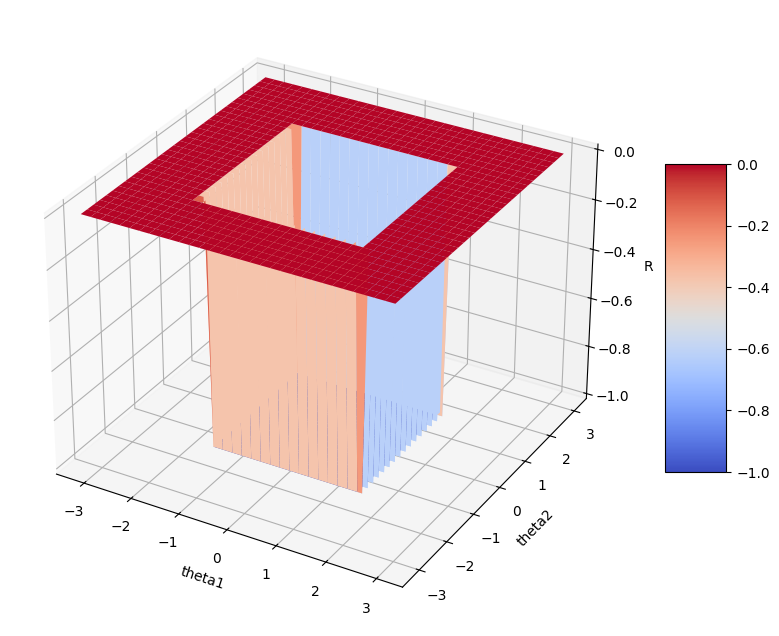

In [10]:
# Tạo thư mục results trong cùng thư mục với file code
current_dir = os.getcwd()
save_dir = osp.join(current_dir, 'results')
os.makedirs(save_dir, exist_ok=True)

# Tạo dữ liệu để vẽ
xRange = np.arange(-np.pi, np.pi, 0.1)
yRange = np.arange(-np.pi, np.pi, 0.1)
toExternal = lambda x, y : toExternalStateRep([x, y, 0, 0])
RFn = compose(rewardFn, toExternal)

# Vẽ đồ thị
plotFunction(RFn, xRange, yRange, 'theta1', 'theta2', 'R')

# Tạo tên file với timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'recovered_{timestamp}.png'
save_path = osp.join(save_dir, filename)

# Lưu hình với chất lượng cao
plt.savefig(save_path, 
            dpi=300,           # độ phân giải cao
            bbox_inches='tight',  # cắt bỏ viền trắng thừa
            pad_inches=0.1,    # thêm padding nhỏ
            format='png')      # định dạng file

# Hiển thị đồ thị
plt.show()


In [ ]:
simulateAgent(agent, True)

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\record_video.py:78: UserWarning: WARN: Overwriting existing videos at d:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\IRL\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is no

325

In [22]:
video_path = current_dir + "/video/rl-video-episode-0.mp4"

display(Video(video_path, embed=True, width=640, height=360))